### Fashion MNIST Autoencoder & MLP Classification
This project demonstrates dimensionality reduction and classification using the Fashion MNIST dataset. Fashion MNIST is a collection of 28x28 pixel images representing different types of wearable clothing. 
To accurately classify this dataset, an Autoencoder is used to compress the image representation down to 64 features, from 784, which is then used to train a simple Logistic Regression classifier, as well as a fully connected multilayer perceptron classifier. 

Performance is assessed through image reconstructions and confusion matricies to find tradeoffs in each approach.

In [157]:
# Fashion MNIST #
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

batch_size = 100 # Number of images we use before updating the gradients
learning_rate = 0.001 # Learning rate for gradient updates
epochs = 12 # Number of times to run through the entire training loop and all batches
latent_dim = 64  # Dimension of the latent space

# Download dataset
path = kagglehub.dataset_download("zalando-research/fashionmnist")

# Load into Pandas
data_train = pd.read_csv(path + "/fashion-mnist_train.csv")
data_test = pd.read_csv(path + "/fashion-mnist_test.csv")

We'll start by seperating the dataset into training and testing portions, which is helpfully provided for us by Kaggle, before moving the data into Pytorch tensors and prepping it for our Autoencoder.

In [158]:
X_train = data_train.iloc[:, 1:].values
y_train = data_train.iloc[:, 0].values

X_test = data_test.iloc[:, 1:].values
y_test = data_test.iloc[:, 0].values

# Normalize the digits to [0,1] for better scaling
X_train = X_train / 255.0
X_test =  X_test / 255.0

# Convert to tensors for processing
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create dataloaders.
train_loader = DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(X_test_tensor, batch_size=batch_size, shuffle=False)

Below is an Autoencoder which takes a 784 dimensional vector, and in three layers compresses it down to only 64. 

A decoder is also defined, which will be used for reconstructing the image data later to evaluate the data lost in this transformation.

In [159]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim = 28*28, hidden_dim = 256, latent_dim = latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction

The model is trained using a standard loop using MSELoss, which is tracked across each epoch of the training cycle.

In [160]:
def train_autoencoder(model, loader, optimizer, loss_metric, epochs):    
    model.train()
    for epoch in range(epochs):
        for batch in loader:
            optimizer.zero_grad()
            reconstruction = model(batch)
            loss = loss_metric(reconstruction, batch)
            loss.backward()
            optimizer.step()
        if epoch % 5 == 0:
            print(f"Epoch #{epoch}'s Loss: {loss.item()}")


# Initialize Model, Loss, and Optimizer
model = Autoencoder()
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_autoencoder(model, train_loader, optimizer, loss, epochs)



Epoch #0's Loss: 0.017722556367516518
Epoch #5's Loss: 0.010397978127002716
Epoch #10's Loss: 0.009962844662368298


The decreasing loss is a good sign, more interesting however, is comparing the original image to the reconstructed form. Not only is it visually interesting, but it provides useful insights on the lossy nature of our model.

In [161]:
def test_autoencoder(model, data, labels):
    model.eval()
    with torch.no_grad():
        reconstructed_data = model(data).detach().numpy()
    return reconstructed_data

sample_images = X_test[:10]
reconstructed_images = test_autoencoder(model, torch.tensor(sample_images, dtype=torch.float32), y_test)



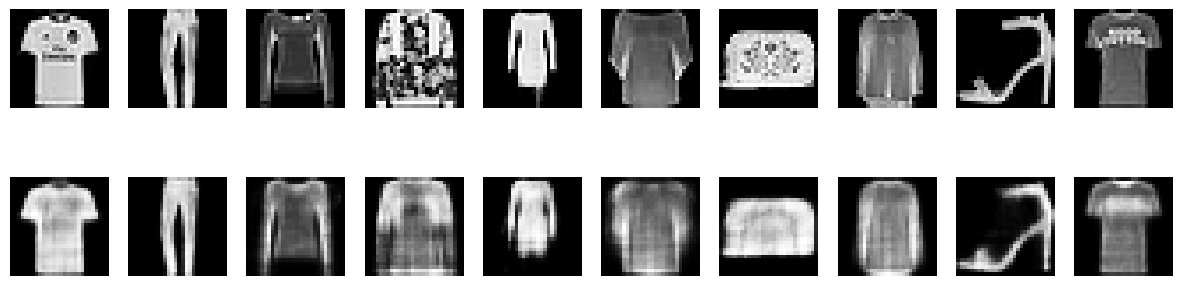

In [162]:
# Visualize original vs. reconstructed images.
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(sample_images[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.show()

Next, we'll encode the data into its latent 64 parameter space, and build a shallow classifier using Linear Regression as well as an MLP model to make predictions on our testing set.

In [163]:
# Project the training data onto the latent space, then
# Convert the latent data from a torch tensor to a numpy array to build the sklearn classifier
# Note: you must first detach the data from the torch tensor network (e.g., my_torch_data.detach().numpy() returns the numpy equivalent)

def encode_data(model, data):
    model.eval()
    with torch.no_grad():
        latent_data = model.encoder(data).detach().numpy()
    return latent_data

latent_train = encode_data(model, X_train_tensor)
latent_test = encode_data(model, X_test_tensor)

In [164]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(latent_train, y_train)

C:\Users\Trist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

Below is the classification report for our testing set. 84% isn't incredible, but it is great considering we're using a Logistic Regression model, trained on only 64 parameters derived from 784.

In [165]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(latent_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.78      0.81      0.79      1000
           1       0.96      0.96      0.96      1000
           2       0.74      0.72      0.73      1000
           3       0.84      0.85      0.85      1000
           4       0.74      0.78      0.75      1000
           5       0.93      0.90      0.92      1000
           6       0.62      0.57      0.60      1000
           7       0.90      0.91      0.90      1000
           8       0.94      0.95      0.94      1000
           9       0.92      0.94      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



The confusion matrix provides some insights on where this model is struggling. Namely, there seems to be a high number of mispredictions across the board for label 6, which are just shirts. This is somewhat expected, as this dataset discriminates between s-shirts (0), pullovers (2), coats (4), and shirts (6). All of these items share a very similar overall shape, which is likely leading to these misclassifications.

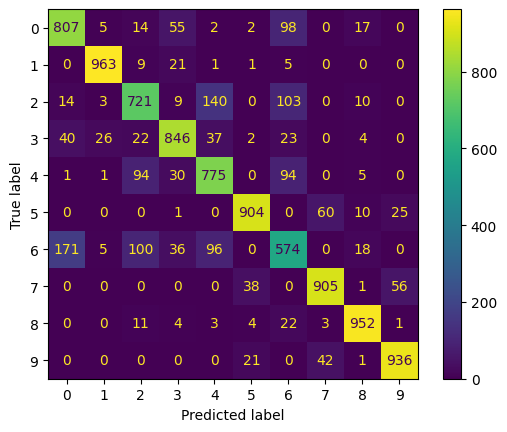

In [166]:
# plot the confusion matrix from the predictions
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot()
plt.show()

In [167]:
# Need to modify our dataloader since we now need the labels (supervised learning)
from torch.utils.data import TensorDataset # useful to join the data and labels for the dataloader

# Now we need to convert the labels to torch tensors as well (supervised)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

train_loader_supervised = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Lastly, we'll train a multilayer perceptron model to classify the images for us. This allows us to train directly on the full size images, at the cost of training and inference compute time.

This model uses 3 hidden dimensions, each halving the number of parameters, whilst the last pushes the 64 parameter latent space into our 10 dimensional classification space, which is then softmaxed to determine the class.

In [168]:
# Define the MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim1=256, hidden_dim2=128, hidden_dim3=64, output_dim=10):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, output_dim),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.network(x)
    

In this case, I choose to use Cross Entropy Loss as its better suited for classification tasks, compared to Mean Square Error which is prefered for regressive models.

In [169]:
# Define the training function (can also just wrap this into the training loop)
def train_mlp(model, loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        for batch_x, batch_y in loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        if epoch % 5 == 0:
            print(f"Epoch #{epoch}'s Loss: {loss.item()}")

# Initialize Model, Loss, and Optimizer
model = MLP(input_dim=28*28, hidden_dim1=256, hidden_dim2=128, output_dim=10)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_mlp(model, train_loader_supervised, optimizer, loss, 10)

Epoch #0's Loss: 1.7332491874694824
Epoch #5's Loss: 1.562309741973877


The full MLP model achieves only a modest improvement of 3% over our Logistic Regressor, which operated on less than 10% of the parameters! Although this model could be optimized further, its clear that there is a lot of redundant data in each sample, which makes a more sophisticated model less useful than one would expect.

The confusion matrix indicates similar classification problems to our Logistic Regression model, that is, a large number of misclassifications for shirts (0), as well as coats (4).

In [172]:
# Predict for all samples (print the classification report, etc)#
model.eval()
with torch.no_grad():
    predictions = torch.argmax(model(X_test_tensor), dim=1).numpy()

print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1000
           1       0.98      0.97      0.98      1000
           2       0.80      0.79      0.80      1000
           3       0.78      0.92      0.84      1000
           4       0.81      0.80      0.80      1000
           5       0.96      0.94      0.95      1000
           6       0.73      0.54      0.62      1000
           7       0.92      0.94      0.93      1000
           8       0.90      0.98      0.94      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.86      0.87      0.86     10000
weighted avg       0.86      0.87      0.86     10000



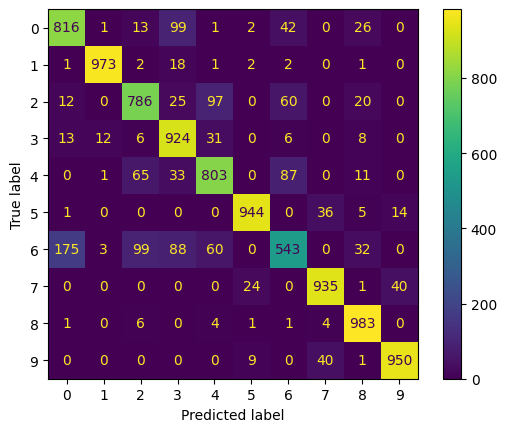

In [171]:
# Plot the confusion matrix
cm_mlp = confusion_matrix(y_test, predictions)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=np.unique(y_test))
disp_mlp.plot()
plt.show()